모델 학습을 진행하기 전 데이터를 스케일링 하려고 한다.  
https://mkjjo.github.io/python/2019/01/10/scaler.html  
다음 페이지에서는 데이터 스케일링이 이런 이유로 인해 필요하다고 한다.  
데이터를 모델링하기 전에는 반드시 스케일링 과정을 거쳐야 한다.  
스케일링을 통해 다차원의 값들을 비교 분석하기 쉽게 만들어주며,  
자료의 오버플로우(overflow)나 언더플로우(underflow)를 방지하고,  
독립 변수의 공분산 행렬의 조건수(condition number)를 감소시켜 최적화 과정에서의 안정성 및 수렴 속도를 향상 시킨다."  
그래서 스케일링의 종류에 대해 살펴보고 기온 예측에 사용되는 데이터에는 어떤 스케일링이 적절한지 모델 학습 결과로 찾아보겠다.  

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [14]:
# 데이터 불러오기
data = pd.read_csv('OBS_ASOS_DD_20210104225316.csv', encoding = 'cp949')  # 2020-01-01~2010-01-01
data1 = pd.read_csv('OBS_ASOS_DD_20210104225407.csv', encoding = 'cp949') # 2010-01-02~2020-01-02
data2 = pd.read_csv('OBS_ASOS_DD_20210104225442.csv', encoding = 'cp949') # 2020-01-03~2021-01-03

data = pd.concat([data,data1,data2],axis=0).reset_index().drop('index',axis=1)

In [10]:
# 데이터 전처리  
# 강수, 적설량과 관련된 변수는 0으로 결측 채우기  
rain_col = [i for i in data.columns if '강수' in i]
snow_col = [i for i in data.columns if '적설' in i]

data[rain_col+snow_col] = data[rain_col+snow_col].fillna(0)

data[['안개 계속시간(hr)','합계 대형증발량(mm)','합계 소형증발량(mm)']] = data[['안개 계속시간(hr)','합계 대형증발량(mm)','합계 소형증발량(mm)']].fillna(0)

# 사용하지 않는 컬럼 버리기
data = data.drop(['기사','강수 계속시간(hr)','10분 최다 강수량(mm)'],axis=1)

time_col=[i for i in data.columns if '시각' in i]
data = data.drop(time_col, axis=1)

data = data.drop(['지점','지점명'], axis=1)

# 시간 순서로 학습시키기 위해 시간 정렬
data = data.sort_values('일시').interpolate(method='linear')

# 보간 후 결측치 없음을 확인
print('결측치 개수 =',data.isna().sum().sum())

결측치 개수 = 0


In [11]:
# 라벨값 설정
data['Y'] = data['평균기온(°C)'].shift(-2)
data = data.dropna()

# train, valid, test dataset 분리
train = data[data['일시']<'2013-01-01']
valid = data[data['일시']>='2013-01-01']
valid = valid[valid['일시']<'2017-01-01']
test = data[data['일시']>='2017-01-01']
print(' train set:',len(train),'개\n',
      'valid set:',len(valid),'개\n',
      'test set',len(test),'개')

# X와 Y분리
trainX,trainY = train.drop(['일시','Y'],axis=1), train['Y']
validX,validY = valid.drop(['일시','Y'],axis=1), valid['Y']
testX,testY = test.drop(['일시','Y'],axis=1), test['Y']

 train set: 4749 개
 valid set: 1461 개
 test set 1462 개


#### 스케일링 대표적인 방법은 4가지가 있다.
1. Standard scaler
2. MinMax scaler
3. MaxAbs scaler
4. Robust scaler  
Scikit-Learn의 패키지를 이용하여 적용해보려한다.  

In [15]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#### DNN

In [7]:
inputs_1 = tf.keras.Input(shape=44)
dense = tf.keras.layers.Dense(50)(inputs_1)
dense = tf.keras.layers.Dense(50)(dense)
dense = tf.keras.layers.Dense(50)(dense)
dense = tf.keras.layers.Dense(50)(dense)
output = tf.keras.layers.Dense(1)(dense)

DNN = tf.keras.Model(inputs=[inputs_1], outputs=output)

optimizer = tf.keras.optimizers.Adam(lr = 0.001)

DNN.compile(loss='mse', optimizer=optimizer)
DNN.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 44)]              0         
_________________________________________________________________
dense (Dense)                (None, 50)                2250      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 9,951
Trainable params: 9,951
Non-trainable params: 0
___________________________________________________________

Train on 4749 samples, validate on 1461 samples
Epoch 1/200
4730/4749 [============================>.] - ETA: 0s - loss: 382.8988
Epoch 00001: val_loss improved from inf to 24.77462, saving model to checkpoint.keras
4749/4749 [==============================] - 5s 1ms/sample - loss: 381.5661 - val_loss: 24.7746
Epoch 2/200
4719/4749 [============================>.] - ETA: 0s - loss: 47.3135
Epoch 00002: val_loss improved from 24.77462 to 14.78325, saving model to checkpoint.keras
4749/4749 [==============================] - 5s 985us/sample - loss: 47.1117 - val_loss: 14.7832
Epoch 3/200
4719/4749 [============================>.] - ETA: 0s - loss: 22.1392
Epoch 00003: val_loss improved from 14.78325 to 11.23077, saving model to checkpoint.keras
4749/4749 [==============================] - 5s 974us/sample - loss: 22.1068 - val_loss: 11.2308
Epoch 4/200
4732/4749 [============================>.] - ETA: 0s - loss: 20.5048
Epoch 00004: val_loss improved from 11.23077 to 9.50582, saving model

Epoch 34/200
4714/4749 [============================>.] - ETA: 0s - loss: 9.0107
Epoch 00034: val_loss improved from 8.56335 to 8.55656, saving model to checkpoint.keras
4749/4749 [==============================] - 6s 1ms/sample - loss: 8.9989 - val_loss: 8.5566
Epoch 35/200
4730/4749 [============================>.] - ETA: 0s - loss: 8.9885
Epoch 00035: val_loss improved from 8.55656 to 8.51577, saving model to checkpoint.keras
4749/4749 [==============================] - 6s 1ms/sample - loss: 8.9815 - val_loss: 8.5158
Epoch 36/200
4697/4749 [============================>.] - ETA: 0s - loss: 8.9654
Epoch 00036: val_loss improved from 8.51577 to 8.47037, saving model to checkpoint.keras
4749/4749 [==============================] - 5s 1ms/sample - loss: 8.9729 - val_loss: 8.4704
Epoch 37/200
4707/4749 [============================>.] - ETA: 0s - loss: 8.9519
Epoch 00037: val_loss improved from 8.47037 to 8.44563, saving model to checkpoint.keras
4749/4749 [==============================

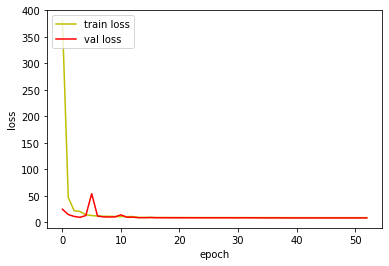

In [8]:
path_checkpoint = 'checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_loss', patience=10,verbose=0)


callback_reduce_lr = ReduceLROnPlateau(monitor='loss',
                                       factor=0.1,
                                       patience=1,
                                       verbose=1)

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_reduce_lr]
hist = DNN.fit(trainX,trainY, validation_data=(validX, validY), 
                 epochs = 200, batch_size=1, callbacks=callbacks, verbose=1)

fig, loss_ax = plt.subplots()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')

plt.show()

MAE
MAE_DNN =  2.1952321309030625
MAE_RNN =  3.4140245797033666
MAE_LSTM =  3.015746226974047


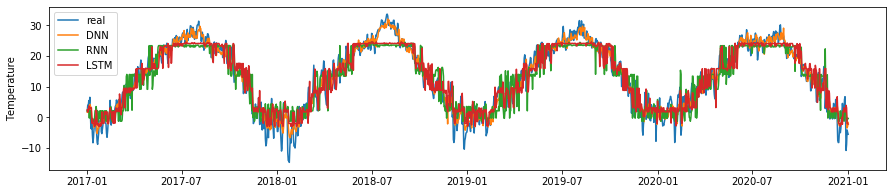

In [56]:
time = pd.to_datetime(test['일시'])

pred_DNN = DNN.predict(testX)
pred_RNN = RNN.predict(testX.values.reshape(-1,1,44)).reshape(-1,)
pred_LSTM = LSTM.predict(testX.values.reshape(-1,1,44))


plt.figure(figsize = (15,3))
plt.plot(time,testY.reset_index()['Y'])
plt.plot(time,pred_DNN)
plt.plot(time,pred_RNN)
plt.plot(time,pred_LSTM)

plt.ylabel('Temperature')
plt.legend(['real','DNN','RNN','LSTM'])

print('MAE')
print('MAE_DNN = ',(((testY-pred_DNN.reshape(-1,))**2)**0.5).mean())
print('MAE_RNN = ',(((testY-pred_RNN.reshape(-1,))**2)**0.5).mean())
print('MAE_LSTM = ',(((testY-pred_LSTM.reshape(-1,))**2)**0.5).mean())